## **1.Describe Trading Idea**

After I got prediction line of SVD Linear Regression Model, I applied curve fitting to smooth line and the get local max. and local min. points on cubic line to make sell/buy decision. Predicted local min. point was buying decision, predicted local max. point was selling decision for algorithm. 


## **2.Define Algo Model Types**

In this case , I tried to LSTM and Linear Regression with SVD. LSTM score was  not satisfied since price is not related with seasonal wave. Linear Regression model had satisfied score for %95 training / %5 test data. I could have increased profit factor by using smaller data but it would not been realistic. In the future, we may be in dramatically increased or decreased price period , we can not predict this situation since price is not only related with statistics. To optimize this situation at least, I took into account %95 previous data for training and then predicted. Other train/test dataset ratio and result are shown below as well. LSTM could be optimized in the further works.

## **3.Define Input Type:** Param./Non-Param/Self-Learning/Hybrid**



## **4.Set Target Metric:** Proft Factor/Sharpe Ratio/Max Drawdown**

I used profit factor metric.

## **5.Define Product Name:** BTCUSDT-perp**

BTCUSDT-perp

## **6.Define Trade-venue:**Binance/CME/Bybit/OTC/DEX

!I do not know where data came.

## **7.Define Backtesting Timeframe**



## **8.Define Backtesting Method&SW**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/MyDrive/cryptoCurrencyPrediction"

/content/drive/MyDrive/cryptoCurrencyPrediction


In [ ]:
!ls

BTCUSDT-perp.ipynb  OnChainvsPriceproj712.xlsx


In [ ]:
!pip install xlrd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install openpyxl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install --upgrade pandas 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 67.3 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5


In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
import os
import pandas as pd
from tensorflow import keras
from google.colab import files
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from keras.layers import CuDNNLSTM
from keras.models import Sequential
plt.rcParams['figure.figsize'] = [16,8]
plt.rcParams.update({'font.size': 18})
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [ ]:
# Load data set
dataframe = pd.ExcelFile('OnChainvsPriceproj712.xlsx')
hourly = pd.read_excel(dataframe, 'Hourly Data')
daily = pd.read_excel(dataframe, 'Daily Data', usecols="A:K")
daily = daily.rename(columns={'Unnamed: 0': 'Date'})
daily.sort_values('Date')
print("Daily Dataframe Shape:",daily.shape)
daily.head()

Daily Dataframe Shape: (1139, 11)


,Date,Bitcoin Price,bitcoin-reserve-risk,bitcoin-realized-profit-usd,bitcoin-realized-loss-usd,bitcoin-total-supply-last-activ-24h,bitcoin-total-supply-last-activ-1d-1w,bitcoin-issuance-btc,bitcoin-wrapped-btc-wbtc-balanc,daysTillHalving,bitcoin-stock-to-flow-ratio-usd
0,2020-01-01T00:00:00Z,7199.661101,0.001793,9.061235e+06,1.611953e+07,79650.894873,537994.946203,2175.0,589.461971,132,8201.932535
1,2020-01-02T00:00:00Z,6985.659023,0.001763,2.850057e+07,4.430710e+07,155086.694678,473260.834515,1762.5,589.461971,131,8192.734785
2,2020-01-03T00:00:00Z,7347.597378,0.001794,4.000605e+07,3.201497e+07,229234.713800,404708.291646,2112.5,594.461971,130,8200.643821
3,2020-01-04T00:00:00Z,7415.202445,0.001821,2.042686e+07,3.873484e+07,114102.789783,528695.665082,2100.0,594.461971,129,8196.930748
4,2020-01-05T00:00:00Z,7410.812541,0.001849,2.169290e+07,1.399913e+07,92918.415125,532005.913111,2037.5,594.461971,128,8190.665125


Text(0, 0.5, 'Bitcoin Price (USD)')

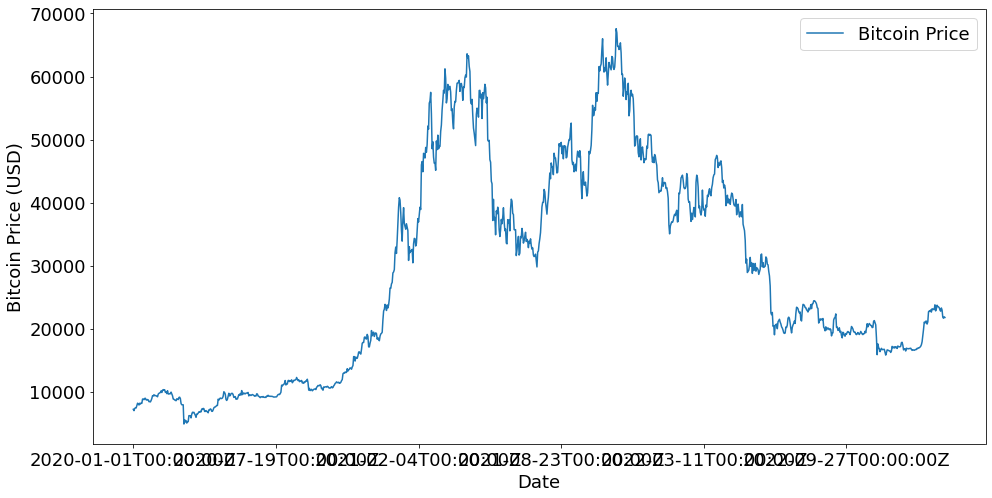

In [ ]:
# Plot Daily Bitcoin Price 
btc_price = daily.plot(x='Date',y='Bitcoin Price')
btc_price.set_xlabel('Date')
btc_price.set_ylabel('Bitcoin Price (USD)')

# SVD Linear Regression

##### Ax=b is typical linear regression equation. In this file, A and b are known. A is values , b is actual data in our case. We can assume that x is our model.

Predicted price will be found by multiplying test data and x 

In [ ]:
# Convert to numpy arrays
A = daily[daily.columns[2:]].to_numpy()
#print (A)
print ("Shape of Features:",A.shape)
b = daily['Bitcoin Price'].to_numpy()
print ("Shape of BTC Dailt Price:",b.shape)
np.isnan(A).any()
print (np.where(A == 0)[0])
np.isnan(b).any()

Shape of Features: (1139, 9)
Shape of BTC Dailt Price: (1139,)
[]


False

##### In this line , we get SVD metrics to get x value from Ax=b.

A = U * S * VT

In [ ]:
# Get SVD matrices (overfitted)
U, S, VT = np.linalg.svd(A,full_matrices=False)
# Get x as model for prediction
x = VT.T @ np.linalg.inv(np.diag(S)) @ U.T @ b

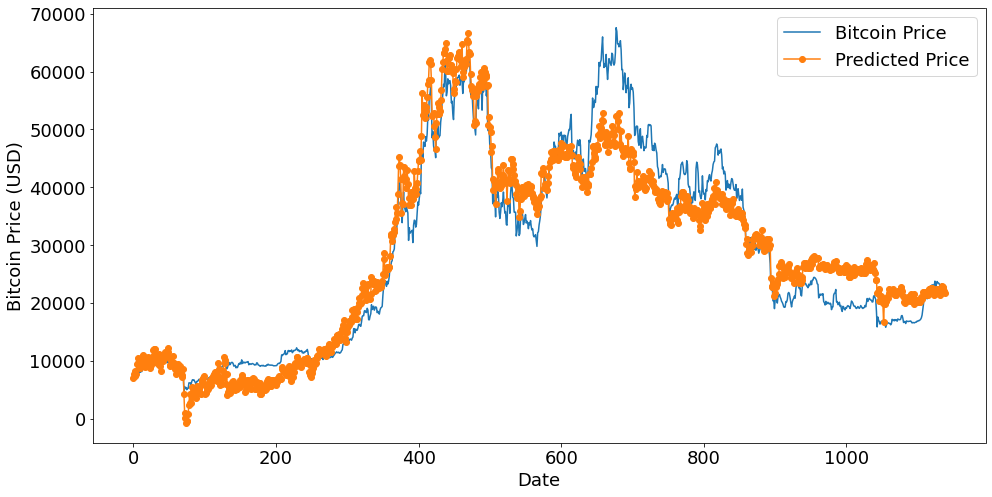

In [ ]:
# Plot 
fig = plt.figure()
plt.plot(b, label='Bitcoin Price')
plt.plot(A@x, '-o',label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Bitcoin Price (USD)')
plt.legend()


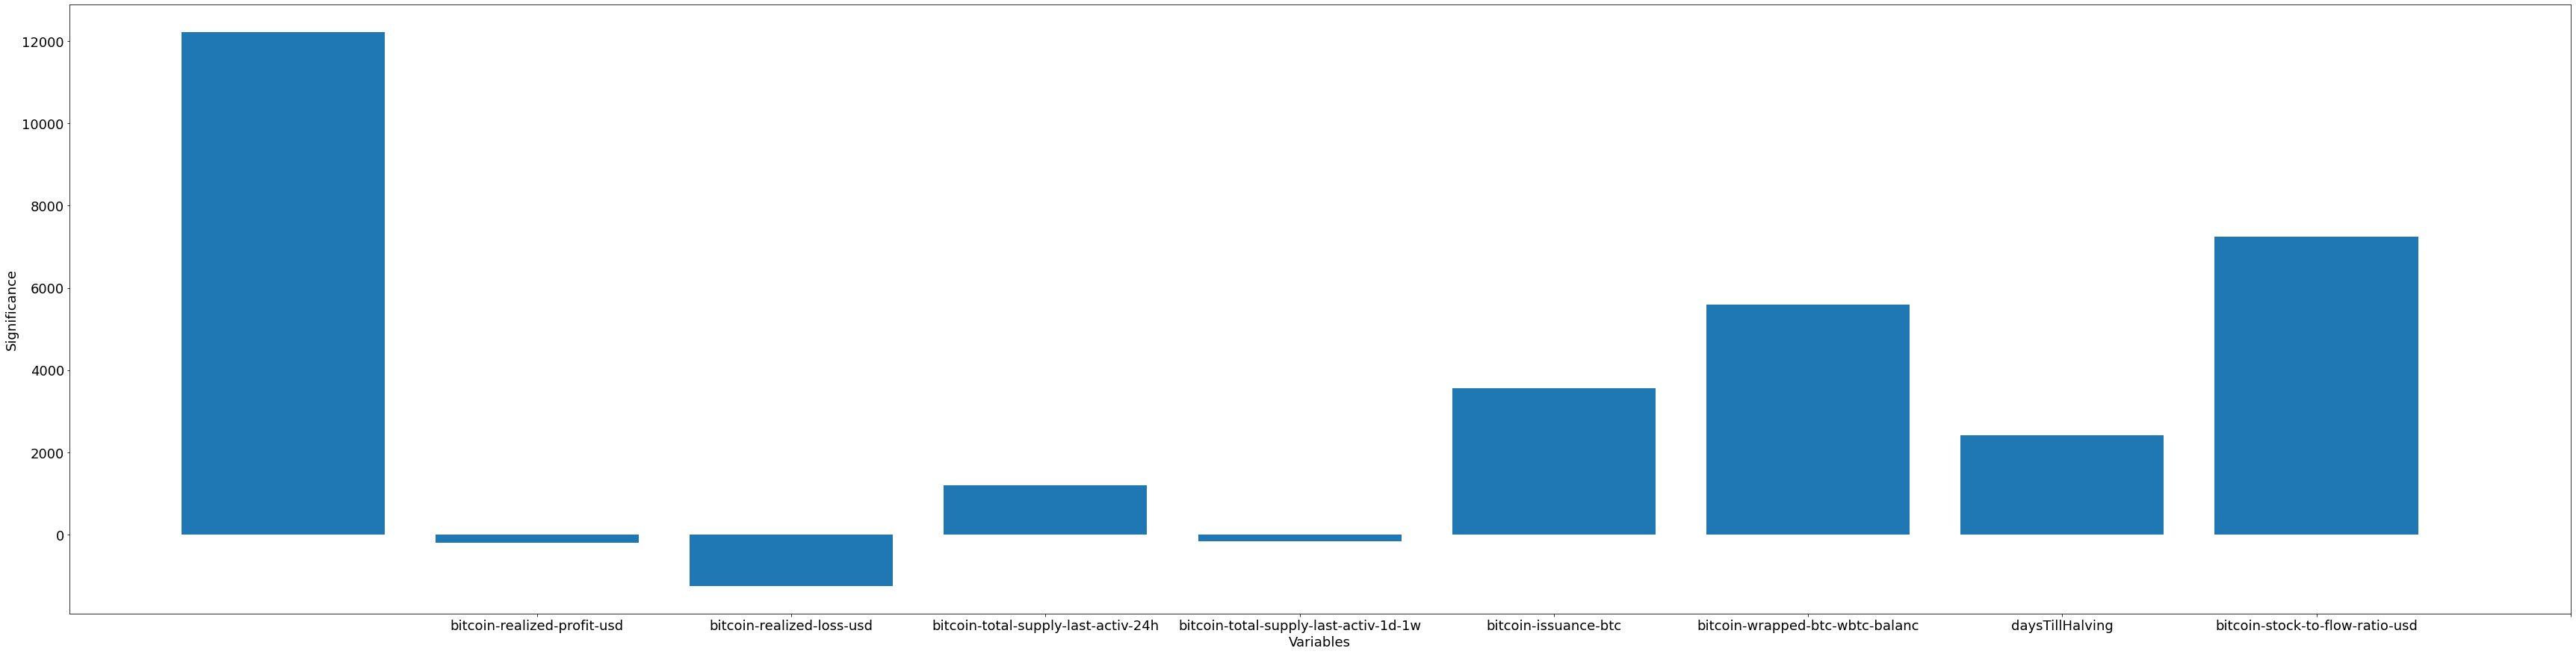

In [ ]:
# Plot significance of variables
plt.rcParams['figure.figsize'] = [60,15]
A_mean = np.mean(A,axis=0)
A_mean = A_mean.reshape(-1,1)
A2 = A - np.ones((A.shape[0],1)) @ A_mean.T

for j in range(A.shape[1]):
  A2std = np.std(A2[:,j])
  A2[:,j] = A2[:,j]/A2std

U, S, VT = np.linalg.svd(A2, full_matrices=False)
x= VT.T @ np.linalg.inv(np.diag(S)) @ U.T @ b 
x_tick = range(1,len(x)+1)
plt.bar(daily.columns[2:],x)
plt.xlabel('Variables')
plt.ylabel('Significance')
plt.xticks(x_tick)
plt.show()

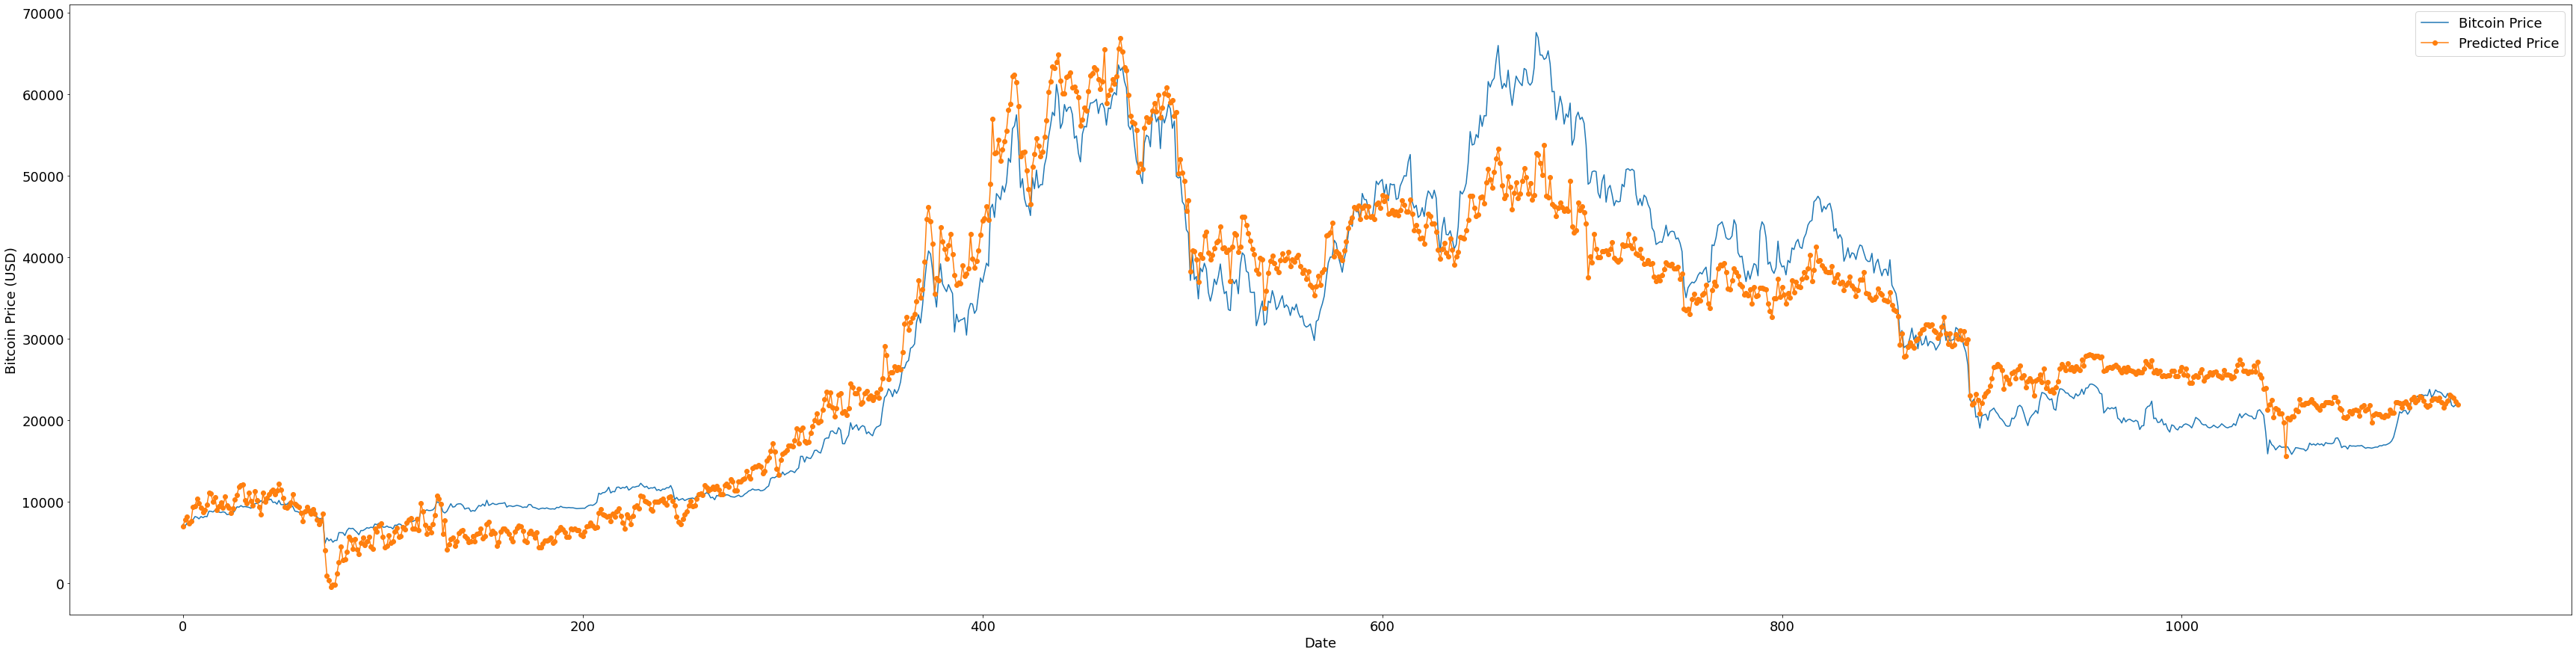

In [ ]:
# Train and test data (Every 2nd/Every 2nd+1)
A_train = A[::2]
b_train = b[::2]
A_test = A[1::2]
b_test = b[1::2]
# Get SVD matrices from train data
U, S, VT = np.linalg.svd(A_train,full_matrices=False)
x = VT.T @ np.linalg.inv(np.diag(S)) @ U.T @ b_train
# Plot 
fig = plt.figure()
plt.plot(b, label='Bitcoin Price')
x1 = A_train@x
x2 = A_test@x
# print (x1[:4])
# print (x2[:4])
Ax1 = x1[0].reshape(-1,1)
Ax2 = np.concatenate((x2.reshape(-1,1),x1[1:].reshape(-1,1)),axis=1).reshape(-1,1)
Ax = np.concatenate((Ax1,Ax2))
# print (Ax[:8])
plt.plot(Ax, '-o', label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Bitcoin Price (USD)')
plt.legend()

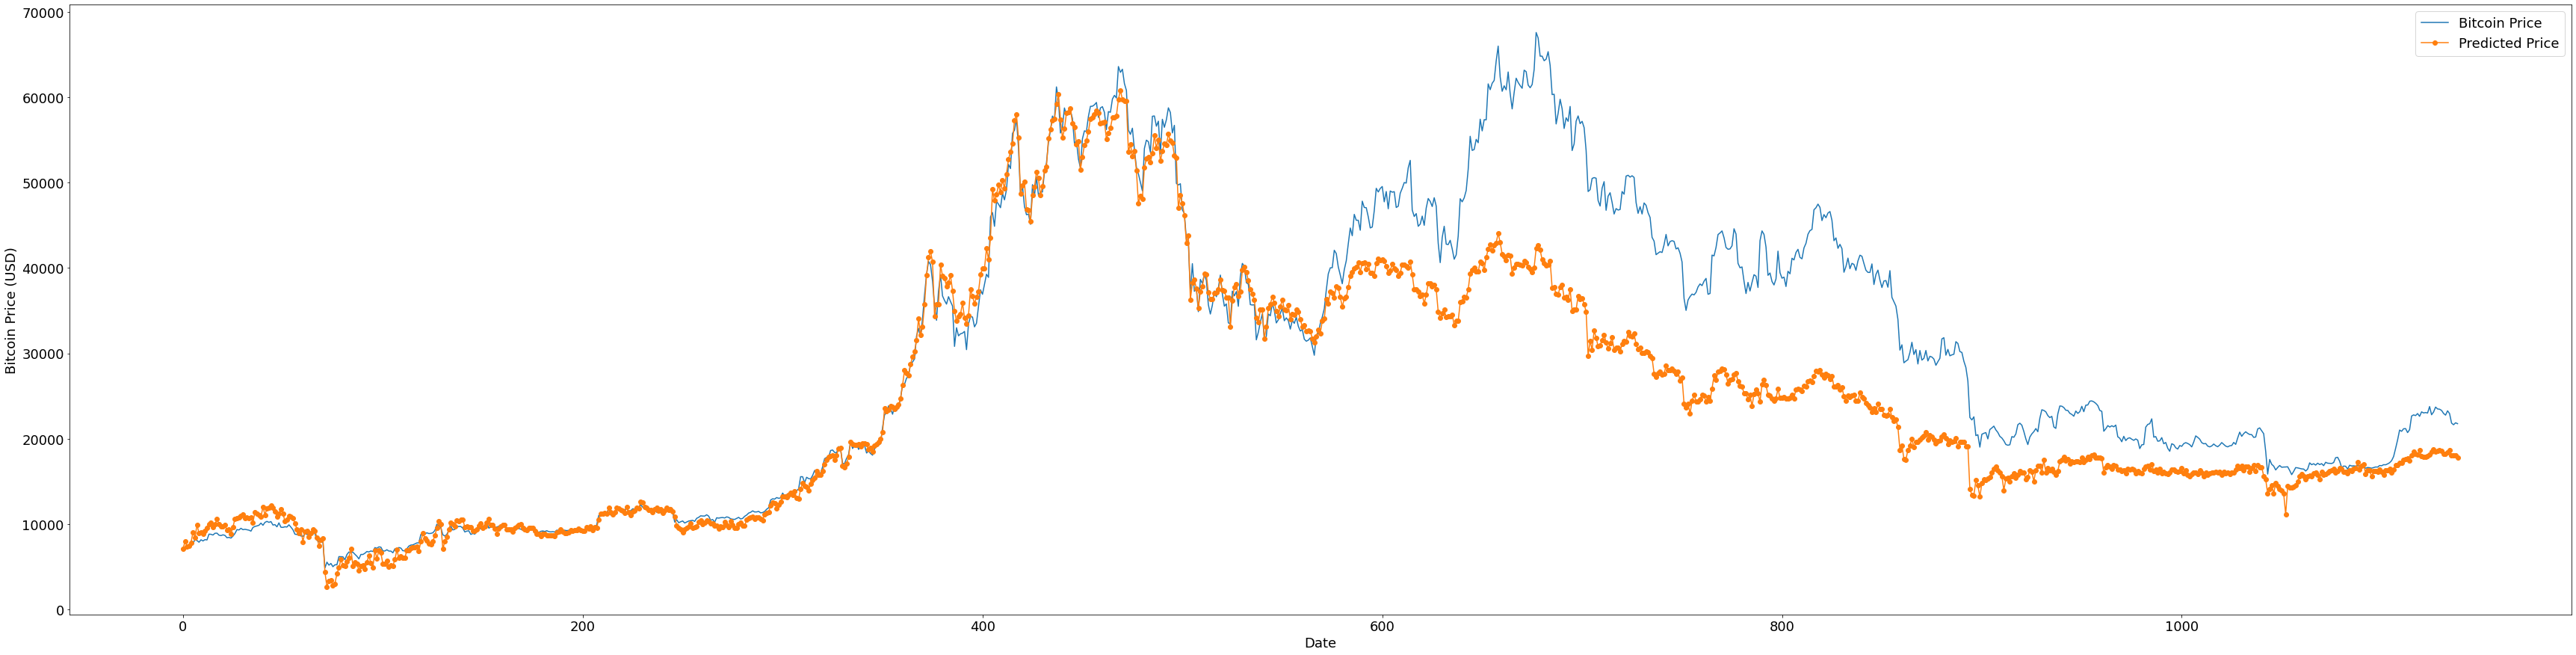

In [ ]:
# Train and test data (First half/Second Half)
n = A.shape[0]//2
A_train = A[:n]
b_train = b[:n]
A_test = A[n:]
b_test = b[n:]
# Get SVD matrices from train data
U, S, VT = np.linalg.svd(A_train,full_matrices=False)
x = VT.T @ np.linalg.inv(np.diag(S)) @ U.T @ b_train
# Plot 
fig = plt.figure()
plt.plot(b, label='Bitcoin Price')
x1 = A_train@x
x2 = A_test@x
Ax = np.concatenate((x1,x2))
plt.plot(Ax, '-o', label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Bitcoin Price (USD)')
plt.legend()

1082


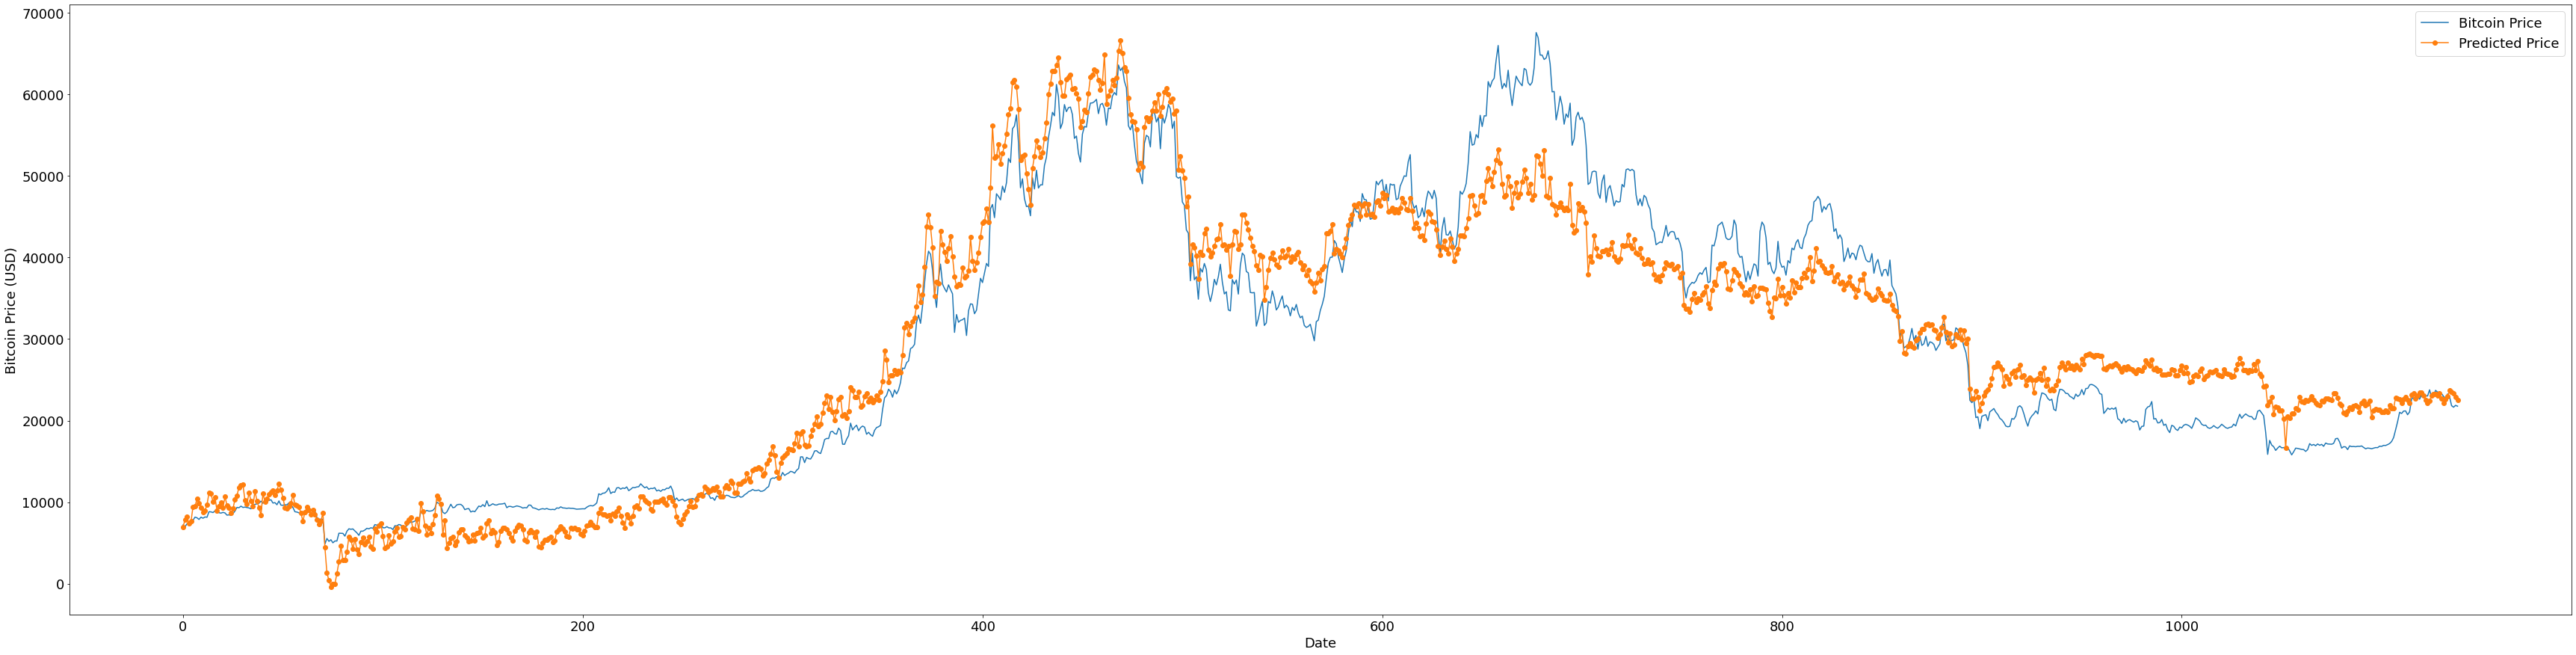

In [ ]:
# Train and test data (First 95 percent/Last 5 percent)
n = int(A.shape[0]*95/100)
print (n)
A_train = A[:n]
b_train = b[:n]
A_test = A[n:]
b_test = b[n:]
# Get SVD matrices from train data
U, S, VT = np.linalg.svd(A_train,full_matrices=False)
x = VT.T @ np.linalg.inv(np.diag(S)) @ U.T @ b_train
# Plot 
fig = plt.figure()
plt.plot(b, label='Bitcoin Price')
x1 = A_train@x
x2 = A_test@x
Ax = np.concatenate((x1,x2))
plt.plot(Ax, '-o', label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Bitcoin Price (USD)')
plt.legend()

# Tensorflow 2 LSTM (In progress..)

In [ ]:
# Scale data
scaler = MinMaxScaler()
scaled_btc_price = scaler.fit_transform(b.reshape(-1,1))
np.isnan(scaled_btc_price).any()
print (scaled_btc_price.shape)

(1139, 1)


In [ ]:
# Create LSTM sequences
n0 = 120
def to_sequences(data, n):
    d = []
    for index in range(len(data) - n):
        d.append(data[index: index + n])
    return np.array(d)

def preprocess(data_raw, n, per_train):
    data = to_sequences(data_raw, n)
    print (data.shape)
    num_train = int(per_train * data.shape[0])
    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]
    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = preprocess(scaled_btc_price, n0, per_train = 0.95)  
print (X_train.shape)
print (X_test.shape)

(1019, 120, 1)
(968, 119, 1)
(51, 119, 1)


In [ ]:
# Model
DROPOUT = 0.2
WINDOW_SIZE = n0 - 1
model = keras.Sequential()
model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))
model.add(Bidirectional(CuDNNLSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))
model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=False)))
model.add(Dense(units=1))
model.add(Activation('linear'))

In [ ]:
# Train
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

In [ ]:
BATCH_SIZE = 64
history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/50
14/14 [==============================] - 14s 149ms/step - loss: 0.0797 - val_loss: 0.0035
Epoch 2/50
14/14 [==============================] - 1s 52ms/step - loss: 0.0140 - val_loss: 0.0010
Epoch 3/50
14/14 [==============================] - 1s 52ms/step - loss: 0.0297 - val_loss: 0.0038
Epoch 4/50
14/14 [==============================] - 1s 52ms/step - loss: 0.0445 - val_loss: 0.0155
Epoch 5/50
14/14 [==============================] - 1s 52ms/step - loss: 0.0191 - val_loss: 0.0035
Epoch 6/50
14/14 [==============================] - 1s 52ms/step - loss: 0.0122 - val_loss: 0.0091
Epoch 7/50
14/14 [==============================] - 1s 52ms/step - loss: 0.0160 - val_loss: 0.0258
Epoch 8/50
14/14 [==============================] - 1s 51ms/step - loss: 0.0235 - val_loss: 0.0057
Epoch 9/50
14/14 [==============================] - 1s 53ms/step - loss: 0.0148 - val_loss: 0.0070
Epoch 10/50
14/14 [==============================] - 1s 58ms/step - loss: 0.0107 - val_loss: 0.0147
Epoch 1

In [ ]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 106ms/step - loss: 9.6706e-04


0.0009670556173659861

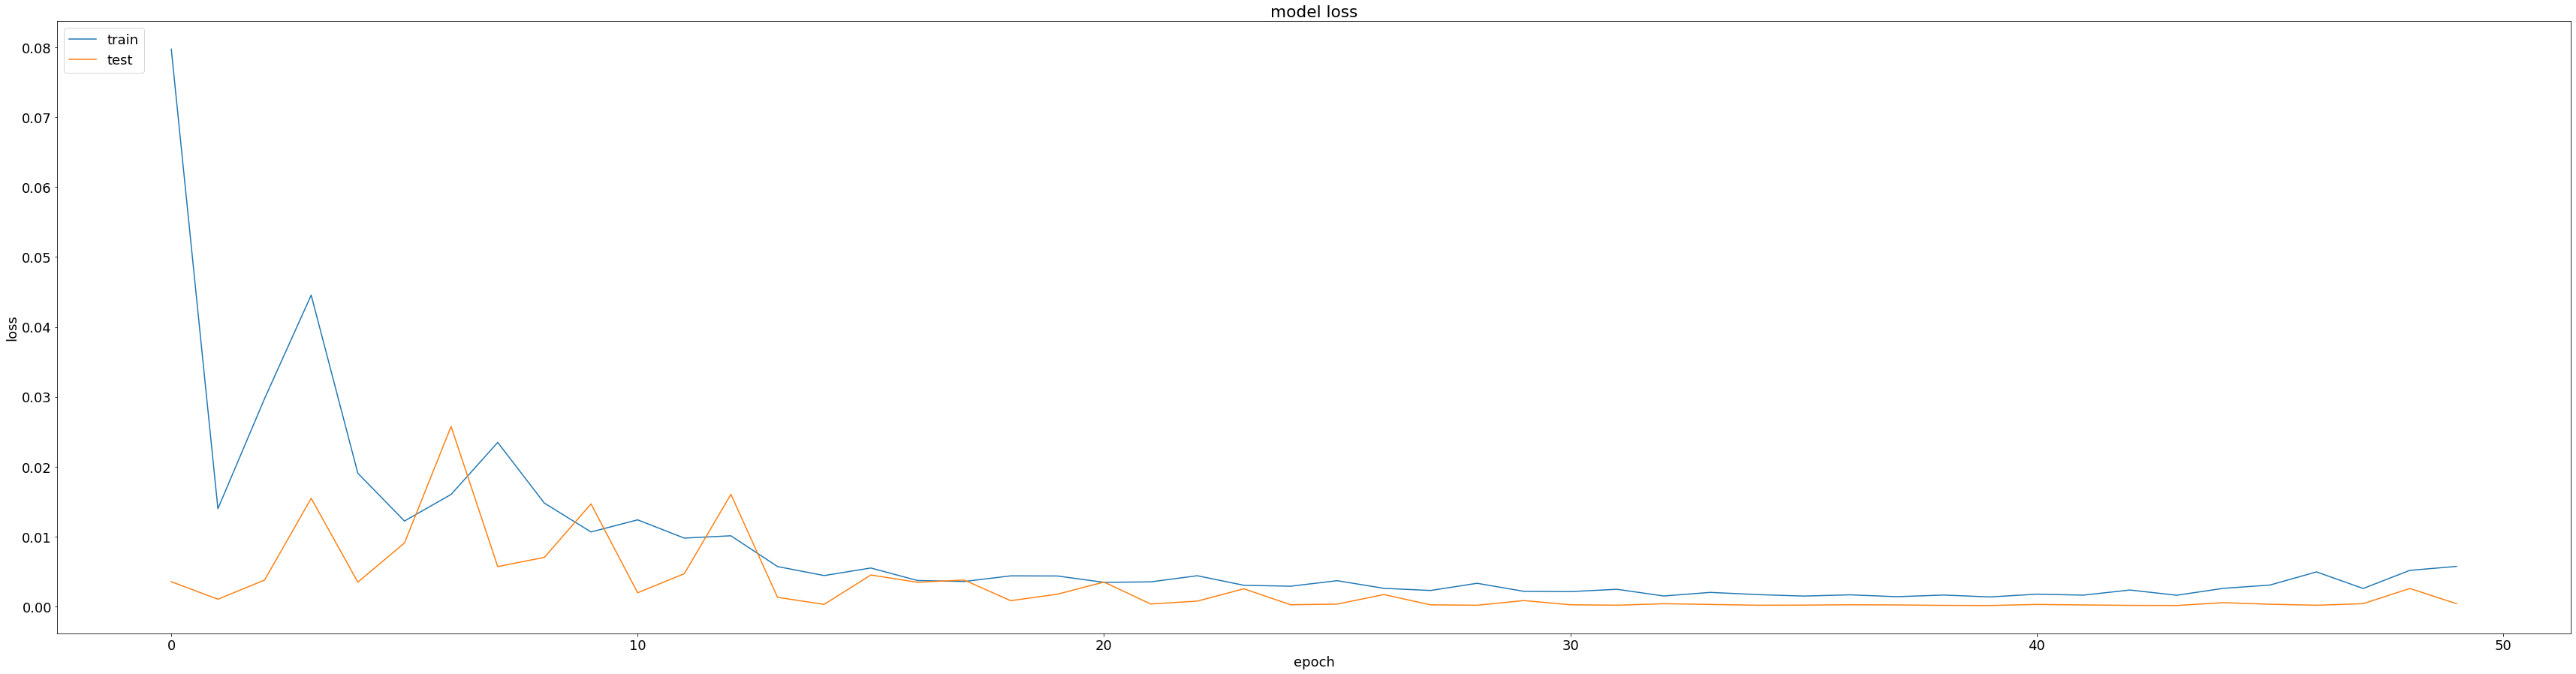

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

2/2 [==============================] - 1s 13ms/step


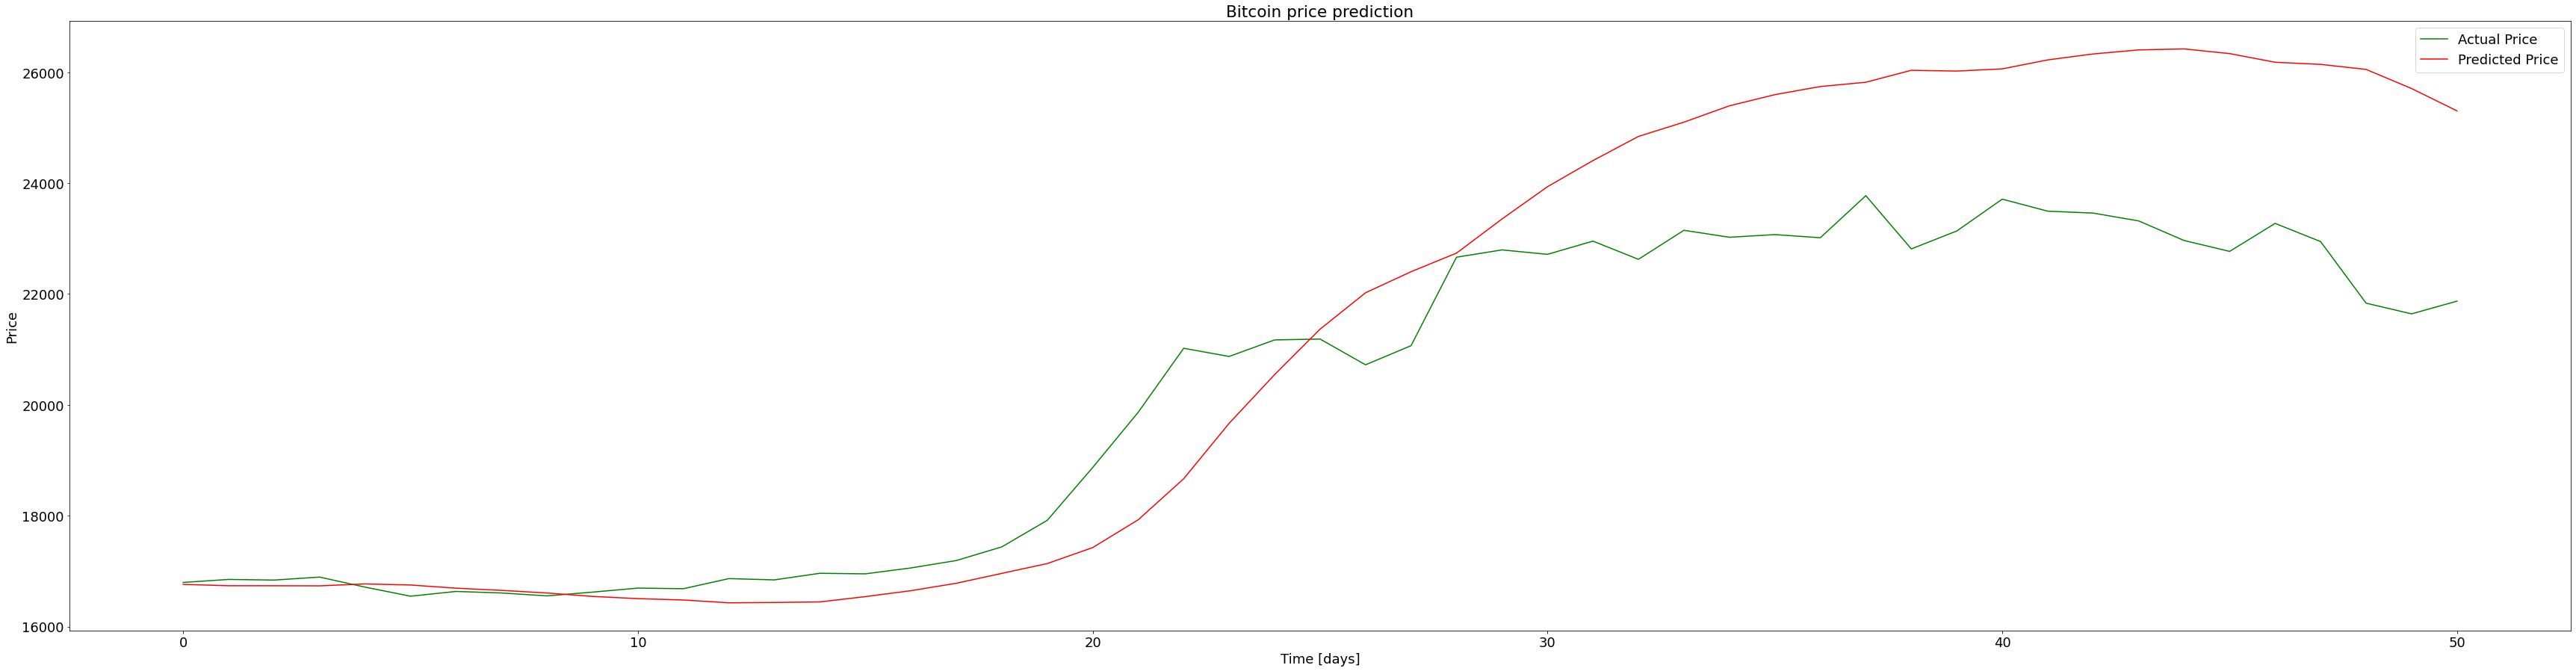

In [ ]:
# Prediction
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();

# Trade Suggestion

#### x2 is prediction of test data. Since we splitted data %95 train %5 test, test days is 57 days. Blue line shows prediction of BTC Price in dataset. Orange line is curve fitting, I prefered to use cure fitting to make prediction line smooth. Also , I used the cubic type of curve to detect local max. and local min. values easily. If you want to change prediction period you can use A_test[your value]. Once I got local min. and local max. in predicted prices , I made a decision for trade. Local min was selling point, local max was buying point for my trade algorithm. Since I did not know previous selling price, I started to calculate profit factor from first buy-sell period.   

(57,)
Selling Points: [16829.60538346 16547.5668696  16682.71588531 21020.72155064
 21171.40010863 23149.55139405 23711.52762911 21835.07047435]
Buying Points: [16850.4640968  16693.9300091  16961.05741131 20873.35288034
 21187.13555809 23015.46167989 22965.07223064]
Loss or Profit Value for Trade Term: -302.89722720859936
Loss or Profit Value for Trade Term: -11.214123788002325
Loss or Profit Value for Trade Term: 4059.6641393282007
Loss or Profit Value for Trade Term: 298.04722829059756
Loss or Profit Value for Trade Term: 1962.4158359643006
Loss or Profit Value for Trade Term: 696.0659492246014
Loss or Profit Value for Trade Term: -1130.0017562862995
Profit Factor in Trade Term: 4.8584789636101755


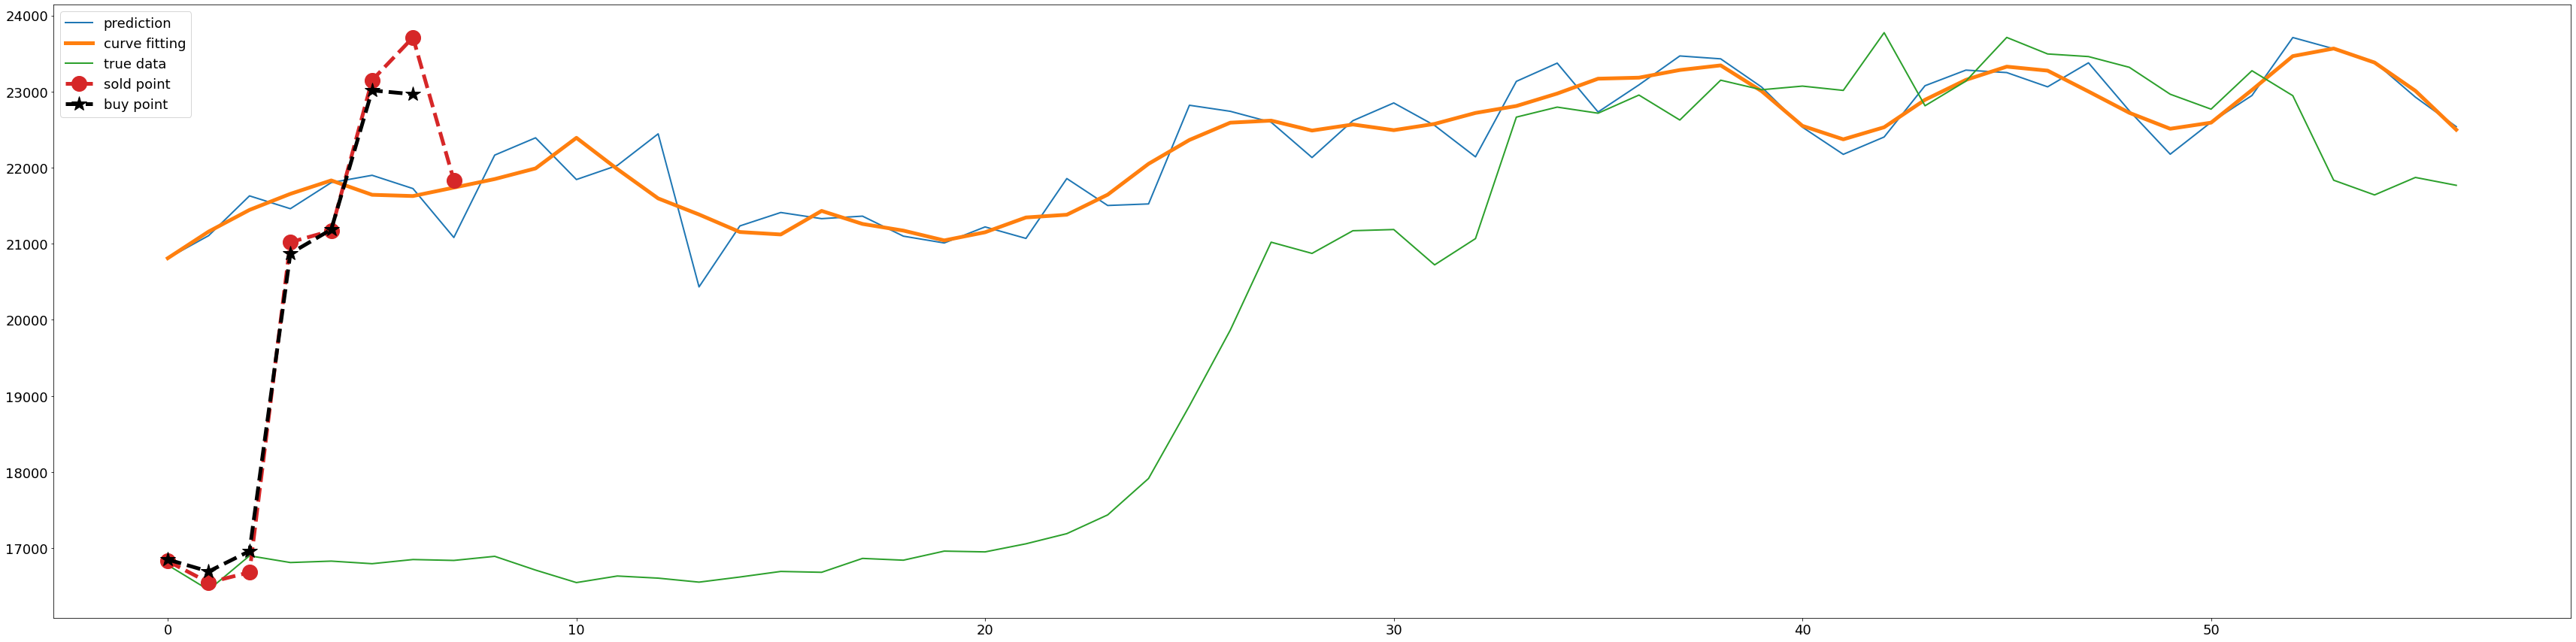

In [ ]:
x2 = A_test@x 
# Buy/Sell Algorithm
from scipy.signal import argrelextrema
from scipy.signal import savgol_filter
# Smoothen the function
print(x2.shape)
c2 = savgol_filter(x2,7,3)#x2 , window_lenght, curve type cubic
fig = plt.figure()
plt.plot(x2, linewidth=2, label='prediction')
plt.plot(c2, linewidth=5, label='curve fitting')
plt.plot(b[-len(x2):],linewidth=2, label='true data')
plt.plot(b[argrelextrema(c2, np.greater)[0]+len(A_train)], linewidth=5, label='sold point',marker="o",markersize=20,linestyle="dashed")
plt.plot(b[argrelextrema(c2, np.less)[0]+len(A_train)], linewidth=5, label='buy point',marker="*",markersize=20,linestyle="dashed",color="k")
plt.legend()
# for local maxima
##print ("Local Max Points Index:",argrelextrema(c2, np.greater))
# for local minima
##print ("Local Min Points Index:",argrelextrema(c2, np.less))
sell = b[argrelextrema(c2, np.greater)[0]+len(A_train)]
buy = b[argrelextrema(c2, np.less)[0]+len(A_train)]
print ("Selling Points:",sell)

print ("Buying Points:",buy)
loss=0
profit=0
for i in range(len(buy)):
  t = sell[i+1]-buy[i]
  if (t < 0):
    loss+=abs(t)
  else:
    profit+=t
  print ("Loss or Profit Value for Trade Term:",t)
print ("Profit Factor in Trade Term:",profit/loss)

# Different Window Lenght Test

In [ ]:
x2 = A_test@x 
# Buy/Sell Algorithm
from scipy.signal import argrelextrema
from scipy.signal import savgol_filter
# Smoothen the function
print(x2.shape)
c2 = savgol_filter(x2,5,3)#x2 , window_lenght, curve type cubic
fig = plt.figure()
plt.plot(x2, linewidth=2, label='prediction')
plt.plot(c2, linewidth=5, label='curve fitting')
plt.plot(b[-len(x2):],linewidth=2, label='true data')
plt.plot(b[argrelextrema(c2, np.greater)[0]+len(A_train)], linewidth=5, label='sold point',marker="o",markersize=20,linestyle="dashed")
plt.plot(b[argrelextrema(c2, np.less)[0]+len(A_train)], linewidth=5, label='buy point',marker="*",markersize=20,linestyle="dashed",color="k")
plt.legend()
# for local maxima
##print ("Local Max Points Index:",argrelextrema(c2, np.greater))
# for local minima
##print ("Local Min Points Index:",argrelextrema(c2, np.less))
sell = b[argrelextrema(c2, np.greater)[0]+len(A_train)]
buy = b[argrelextrema(c2, np.less)[0]+len(A_train)]
print ("Selling Points:",sell)

print ("Buying Points:",buy)
loss=0
profit=0
for i in range(len(buy)):
  t = sell[i+1]-buy[i]
  if (t < 0):
    loss+=abs(t)
  else:
    profit+=t
  print ("Loss or Profit Value for Trade Term:",t)
print ("Profit Factor in Trade Term:",profit/loss)